In [5]:
# General
import pickle
import pandas as pd
import numpy as np
import math
import datetime
from scipy import stats
import itertools
from pandas.plotting import register_matplotlib_converters
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer, make_column_selector

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-colorblind')
plt.rc('axes', grid=True)
plt.rc('savefig', format='png', transparent=False, facecolor='None')

# Torch
import torch.nn as nn
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import trange
from torchmetrics.regression import MeanAbsolutePercentageError

# Set options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
warnings.filterwarnings('ignore')

In [8]:
# load data
with open("../data/mlp_onehot_ypred-Oct25_2015.pkl", "rb") as f: pred = pickle.load(f)

pred

,zcode,month,y,y_hat,epoch,batch,Type
0,44060,"[1, 2, 3, 4, 5, 6]","[-0.7437949, -0.51827353, -0.44754347, -0.4757...","[-0.23064274, -0.22738682, -0.2347814, -0.2423...",0,0,Train
1,30045,"[1, 2, 3, 4, 5, 6]","[-0.30583, -0.22720246, -0.21505915, -0.161936...","[-0.28985828, -0.2598362, -0.2505151, -0.26319...",0,1,Train
2,44202,"[1, 2, 3, 4, 5, 6]","[-0.05915824, -0.13353607, -0.26515195, -0.144...","[-0.2850164, -0.26740414, -0.27537352, -0.2949...",0,2,Train
3,30134,"[1, 2, 3, 4, 5, 6]","[-0.23488107, -0.2414517, -0.13479453, -0.1397...","[-0.24340682, -0.22758086, -0.22049662, -0.216...",0,0,Train
4,30294,"[1, 2, 3, 4, 5, 6]","[-0.32961792, -0.11624117, -0.14929911, -0.174...","[-0.29972273, -0.28659004, -0.28553534, -0.278...",0,1,Train
...,...,...,...,...,...,...,...
54265,44102,"[1, 2, 3, 4, 5, 6]","[-0.46073833, -0.31966212, -0.3032269, -0.2953...","[-0.22724038, -0.17340171, -0.12864757, -0.120...",29,1,Test
54266,30316,"[1, 2, 3, 4, 5, 6]","[-0.7019505, -0.5627883, -0.6741058, -0.545197...","[-0.22147028, -0.13650672, -0.044319287, -0.00...",29,2,Test
54267,44121,"[1, 2, 3, 4, 5, 6]","[-0.45367628, -0.6325094, -0.6822739, -0.66352...","[-0.15077874, -0.25563386, -0.37534505, -0.410...",29,0,Test
54268,30038,"[1, 2, 3, 4, 5, 6]","[-0.68430656, -0.604479, -0.6343032, -0.560413...","[-0.18440416, -0.08533852, 0.022654325, 0.0582...",29,1,Test


In [10]:
# load data
with open("../data/mlp_onehot_traintest_results-Oct25_2015.pkl", "rb") as error: error = pickle.load(f)

error

,epoch,batch_num,mape,loss_mse,Type,Model,TrainTestCutoffDate,Train Size,Test Size,hdim,BatchSize
0,0,0,0.62792754,0.03775986,Train,MLP-ziponehot,2021-03-01,12,6,16,3
1,0,1,0.44559744,0.014476816,Train,MLP-ziponehot,2021-03-01,12,6,16,3
2,0,2,0.3434664,0.019172061,Train,MLP-ziponehot,2021-03-01,12,6,16,3
3,0,3,0.26069716,0.004374191,Train,MLP-ziponehot,2021-03-01,12,6,16,3
4,0,4,0.20801163,0.007935341,Train,MLP-ziponehot,2021-03-01,12,6,16,3
...,...,...,...,...,...,...,...,...,...,...,...
18085,29,598,0.9916491,0.32963854,Test,MLP-ziponehot,2021-03-01,12,6,16,3
18086,29,599,1.187847,0.42746145,Test,MLP-ziponehot,2021-03-01,12,6,16,3
18087,29,600,1.2453634,0.3569335,Test,MLP-ziponehot,2021-03-01,12,6,16,3
18088,29,601,0.7336009,0.18331744,Test,MLP-ziponehot,2021-03-01,12,6,16,3


In [61]:
# check best epoch
checkpoint = torch.load("../model_info.pt")
epoch = checkpoint['epoch']
test_loss = checkpoint['loss']

print(epoch)
print(test_loss)

1
0.040018704


In [39]:
train_error = error[error['Type'] == 'Train']
test_error = error[error['Type'] == 'Test']

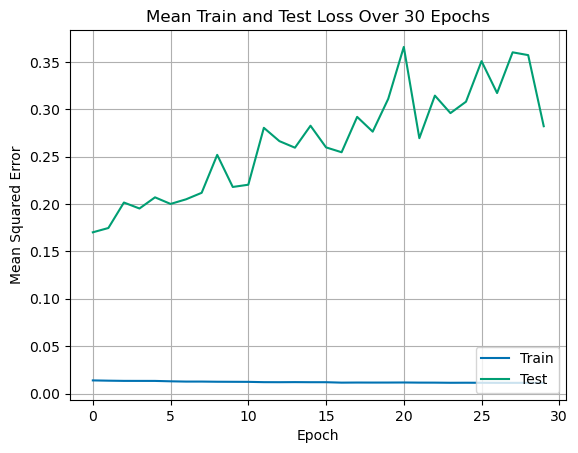

In [132]:
mean_loss_train = train_error.groupby('epoch')['loss_mse'].agg('mean')
mean_loss_test = test_error.groupby('epoch')['loss_mse'].agg('mean')
plt.plot(mean_loss_train, label ='Train')
plt.plot(mean_loss_test, label ='Test')

plt.title('Mean Train and Test Loss Over 30 Epochs')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend(loc ="lower right")

plt.savefig('traintest_loss')

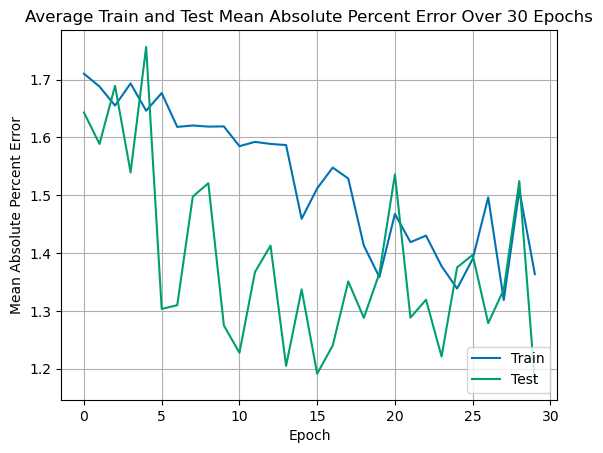

In [133]:
mean_mape_train = train_error.groupby('epoch')['mape'].agg('mean')
mean_mape_test = test_error.groupby('epoch')['mape'].agg('mean')
plt.plot(mean_mape_train, label ='Train')
plt.plot(mean_mape_test, label ='Test')

plt.title('Average Train and Test Mean Absolute Percent Error Over 30 Epochs')
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Percent Error")
plt.legend(loc ="lower right")

plt.savefig('traintest_mape')

In [ ]:
# austin's plot
sns.kdeplot(data=cle_exo_compare, x='mape', hue='model', clip=(0,0.75))
plt.title('Cleveland Prophet Model - Univariate vs Multivariate')
plt.xlabel('mean MAPE - all zip codes')
plt.savefig('cle-proph-kde')
plt.show()

In [26]:
pred.groupby(['zcode', 'Type', 'epoch'])['batch'].count()

zcode  Type   epoch
30002  Test   0        10
              1        10
              2        10
              3        10
              4        10
                       ..
44333  Train  25       56
              26       56
              27       56
              28       56
              29       56
Name: batch, Length: 10860, dtype: int64

In [91]:
# look at predictions for epoch 1
pred = pred[pred['epoch'] == 1]

In [94]:
pred['Market'] = pred['zcode'].apply(lambda x: 'Atlanta' if x.startswith('3') else 'Cleveland')
pred.head()

,zcode,month,y,y_hat,epoch,batch,Type,Market
10134,30309,"[1, 2, 3, 4, 5, 6]","[-0.3201441, -0.31277367, -0.39444977, -0.3627...","[-0.26739135, -0.29978788, -0.32959133, -0.343...",1,0,Train,Atlanta
10135,44126,"[1, 2, 3, 4, 5, 6]","[-0.5175795, -0.36406246, -0.25350344, -0.0934...","[-0.2551615, -0.21760744, -0.23999615, -0.2531...",1,1,Train,Cleveland
10136,30318,"[1, 2, 3, 4, 5, 6]","[-0.15507357, -0.17222874, -0.15895347, -0.257...","[-0.24075952, -0.23800404, -0.22565553, -0.227...",1,2,Train,Atlanta
10137,30013,"[1, 2, 3, 4, 5, 6]","[-0.3456613, -0.22172357, -0.20994858, -0.1466...","[-0.25073308, -0.2444736, -0.22720319, -0.2218...",1,0,Train,Atlanta
10138,30303,"[1, 2, 3, 4, 5, 6]","[-0.28052595, -0.37615293, -0.4033258, -0.3478...","[-0.27100572, -0.28794456, -0.26898968, -0.268...",1,1,Train,Atlanta


In [112]:
pred_test = pred[pred['Type'] == 'Test']
pred_train = pred[pred['Type'] == 'Train']

In [104]:
train_avg = pred_train.groupby('Market')[['y','y_hat']].mean()
test_avg = pred_test.groupby('Market')[['y','y_hat']].mean()
train_avg

,y,y_hat
Market,,
Atlanta,"[-0.24891782, -0.24396712, -0.24092467, -0.236...","[-0.25577092, -0.24991691, -0.2472561, -0.2433..."
Cleveland,"[-0.3372154, -0.33390677, -0.33120564, -0.3313...","[-0.32428232, -0.3235217, -0.3193332, -0.31760..."


In [110]:
train_avg['y']['Atlanta']

array([-0.24891782, -0.24396712, -0.24092467, -0.23633622, -0.2317576 ,
       -0.22786146], dtype=float32)

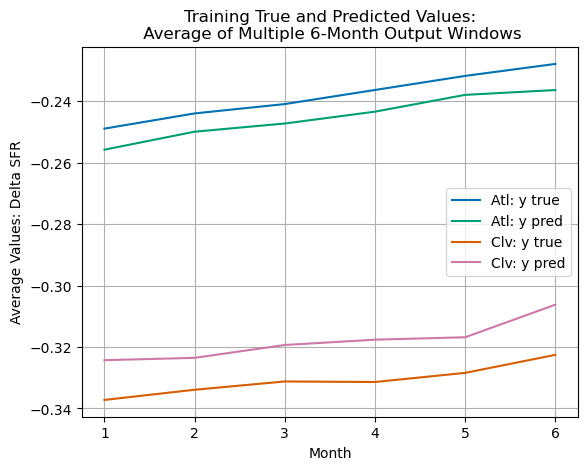

In [126]:
plt.plot(train_avg['y']['Atlanta'], label ='Atl: y true')
plt.plot(train_avg['y_hat']['Atlanta'], label ='Atl: y pred')

plt.plot(train_avg['y']['Cleveland'], label ='Clv: y true')
plt.plot(train_avg['y_hat']['Cleveland'], label ='Clv: y pred')

plt.title('Training True and Predicted Values:\n Average of Multiple 6-Month Output Windows')
plt.xticks(ticks = np.arange(6), labels = [1,2,3,4,5,6])
plt.xlabel("Month")
plt.ylabel("Average Values: Delta SFR")
plt.legend(loc ="best")

plt.savefig('train_ytrueypred')

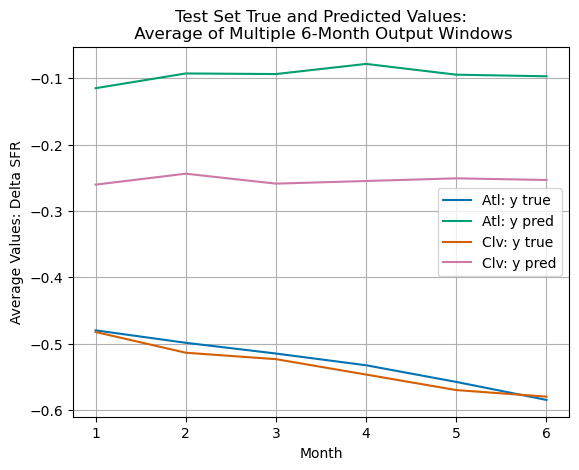

In [127]:
plt.plot(test_avg['y']['Atlanta'], label ='Atl: y true')
plt.plot(test_avg['y_hat']['Atlanta'], label ='Atl: y pred')

plt.plot(test_avg['y']['Cleveland'], label ='Clv: y true')
plt.plot(test_avg['y_hat']['Cleveland'], label ='Clv: y pred')

plt.title('Test Set True and Predicted Values:\n Average of Multiple 6-Month Output Windows')
plt.xticks(ticks = np.arange(6), labels = [1,2,3,4,5,6])
plt.xlabel("Month")
plt.ylabel("Average Values: Delta SFR")
plt.legend(loc ="best")

plt.savefig('test_ytrueypred')

In [66]:
zip_pred = pred_test[pred_test['zcode'] == '44060'].reset_index()
zip_pred

,index,zcode,month,y,y_hat,epoch,batch,Type
0,1858,44060,"[1, 2, 3, 4, 5, 6]","[-0.41211435, -0.36235484, -0.3983637, -0.6308...","[-0.2338098, -0.22332045, -0.25507236, -0.2656...",1,1,Test
1,1984,44060,"[1, 2, 3, 4, 5, 6]","[-0.57069206, -0.7123059, -0.57254696, -0.6881...","[-0.26709506, -0.2566668, -0.278004, -0.276582...",1,1,Test
2,2076,44060,"[1, 2, 3, 4, 5, 6]","[-0.3983637, -0.63080984, -0.6222097, -0.57069...","[-0.23669738, -0.2362938, -0.2811859, -0.29311...",1,0,Test
3,2127,44060,"[1, 2, 3, 4, 5, 6]","[-0.57254696, -0.6881016, -0.5523603, -0.58321...","[-0.33229387, -0.30907962, -0.304872, -0.26930...",1,0,Test
4,2159,44060,"[1, 2, 3, 4, 5, 6]","[-0.47985896, -0.41211435, -0.36235484, -0.398...","[-0.24315631, -0.21903792, -0.22753407, -0.233...",1,2,Test
5,2190,44060,"[1, 2, 3, 4, 5, 6]","[-0.7123059, -0.57254696, -0.6881016, -0.55236...","[-0.2928815, -0.2760564, -0.28802928, -0.27524...",1,0,Test
6,2920,44060,"[1, 2, 3, 4, 5, 6]","[-0.36235484, -0.3983637, -0.63080984, -0.6222...","[-0.2330122, -0.23044223, -0.27395397, -0.2868...",1,1,Test
7,2997,44060,"[1, 2, 3, 4, 5, 6]","[-0.63080984, -0.6222097, -0.57069206, -0.7123...","[-0.2467558, -0.24261113, -0.27889588, -0.2876...",1,0,Test
8,3407,44060,"[1, 2, 3, 4, 5, 6]","[-0.6222097, -0.57069206, -0.7123059, -0.57254...","[-0.25771752, -0.2534432, -0.284552, -0.291754...",1,2,Test
9,3501,44060,"[1, 2, 3, 4, 5, 6]","[-0.5333051, -0.47985896, -0.41211435, -0.3623...","[-0.24744017, -0.22065479, -0.22549109, -0.229...",1,0,Test


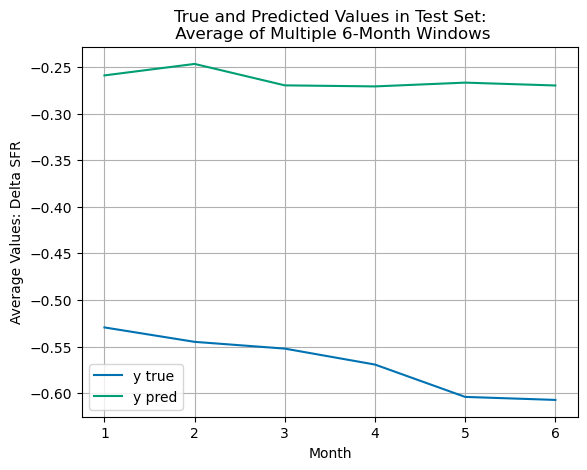

In [128]:
mean_y = np.mean(zip_pred['y'], axis = 0)
mean_yhat = np.mean(zip_pred['y_hat'], axis = 0)
plt.plot(mean_y, label ='y true')
plt.plot(mean_yhat, label ='y pred')

plt.title('True and Predicted Values in Test Set:\n Average of Multiple 6-Month Windows')
plt.xticks(ticks = np.arange(6), labels = [1,2,3,4,5,6])
plt.xlabel("Month")
plt.ylabel("Average Values: Delta SFR")
plt.legend(loc ="best")

plt.savefig('ytrue_ypred_avg')

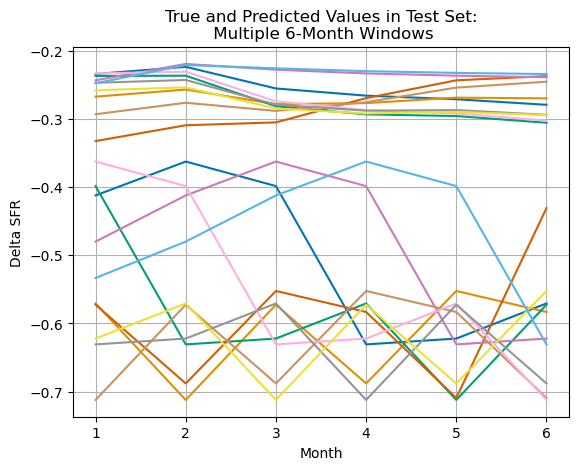

In [129]:
colors = sns.color_palette(palette='colorblind').as_hex()

for i in zip_pred.index:
    plt.plot(zip_pred['y'][i], c = colors[i])
    plt.plot(zip_pred['y_hat'][i], c = colors[i])
    
plt.title('True and Predicted Values in Test Set:\n Multiple 6-Month Windows')
plt.xticks(ticks = np.arange(6), labels = [1,2,3,4,5,6])
plt.xlabel("Month")
plt.ylabel("Delta SFR")
#plt.legend(loc ="best")

plt.savefig('ytrue_ypred')